In [13]:
import requests
#from bs4 import BeautifulSoup
import pandas as pd
#from fake_useragent import UserAgent
from selenium import webdriver
import time
from random import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.cross_validation import cross_val_score, train_test_split, KFold, cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import ml_insights as mli
import pickle

ImageRes=250
W=100000

<h1>Data Scraping</h1>

In [ ]:
#Gets all webpages and saves them locally
#First Data Scrape on Wed Sept 27 
for i in range(0,520):
    
    url='https://www.carmax.com/search#Distance=all&ExposedCategories=\249+250+1001+1000+265+999+772&ExposedDimensions=249+250+1001+1000+265+999+772&Page='\
    +str(i)+'&PerPage=100&SortKey=14&Zip=30144'
    

    browser=webdriver.Chrome('/home/sufyan/Metis/Week2/chromedriver')
    browser.get(url)
    time.sleep(random()*5)
    text=browser.page_source

    f = open('/home/sufyan/Metis/Week2/webs/'+str(i)+".html","w")
    f.write(text)
    f.close()

    browser.close()


In [ ]:
#pulls data from all local webpages and stores in dataframe, saving a new external csv every 50 pages for redundancy

df=pd.DataFrame(columns=['YearMakeModel','Price','Mileage','Num_reviews','location','features','specs','stars' ])


for i in range(0,520):
    overall_list=[]
    url='file:///home/sufyan/Metis/Week2/webs/'+str(i)+'.html'
    try: 
        if i%50==0: df.to_csv('Dataframe'+str(i)+'.csv', sep="|")
        browser=webdriver.Chrome('/home/sufyan/Metis/Week2/chromedriver')
        browser.get(url)
    except: browser.close()
    for j in range(0,105):
        currentlist=[]
        try:
            x_yearmakemodel='//*[@id="universal-search-client"]/div/div/div[1]/div[4]/div[2]/div[1]/div['+str(j)+']/div/div/div[2]/h3/a/span'
            currentlist.append(browser.find_element_by_xpath(x_yearmakemodel).text)
            
            x_price='//*[@id="universal-search-client"]/div/div/div[1]/div[4]/div[2]/div[1]/div['+str(j)+']/div/div/div[2]/div[1]/div[1]/span/span/span[3]'
            currentlist.append(browser.find_element_by_xpath(x_price).text)
            
            x_mileage='//*[@id="universal-search-client"]/div/div/div[1]/div[4]/div[2]/div[1]/div['+str(j)+']/div/div/div[2]/div[1]/div[2]/span'
            currentlist.append(browser.find_element_by_xpath(x_mileage).text)
            
            x_numrev='//*[@id="universal-search-client"]/div/div/div[1]/div[4]/div[2]/div[1]/div['+str(j)+']/div/div/div[2]/div[1]/div[3]/span[1]/span'
            currentlist.append(browser.find_element_by_xpath(x_numrev).text)
            
            x_loc='//*[@id="universal-search-client"]/div/div/div[1]/div[4]/div[2]/div[1]/div['+str(j)+']/div/div/div[2]/div[3]/div'
            currentlist.append(browser.find_element_by_xpath(x_loc).text)
            
            x_features='#universal-search-client > div > div > div.vehicle-browse.material > div.content.vehicle-browse--content.material > div.universal-search.vehicle-browse--results-wrap.material > div:nth-child(1) > div:nth-child('+str(j)+') > div > div > div.vehicle-at-a-glance.mobile-hidden > div > div > p:nth-child(2) > span'
            currentlist.append(browser.find_element_by_css_selector(x_features).text)
            
            x_specs='//*[@id="universal-search-client"]/div/div/div[1]/div[4]/div[2]/div[1]/div['+str(j)+']/div/div/div[3]/div/div/p[2]/span'
            currentlist.append(browser.find_element_by_xpath(x_specs).text)
            
            numstars=0.0
            for k in range(1,6):
                tempstar=browser.find_element_by_css_selector('#universal-search-client > div > div > div.vehicle-browse.material > div.content.vehicle-browse--content.material > div.universal-search.vehicle-browse--results-wrap.material > div:nth-child(1) > div:nth-child('+str(j)+') > div > div > div.vehicle-browse--result--info > div.vehicle-browse--result--blurb-wrap > div.vehicle-browse--result--blurb.vehicle-browse--result--blurb-reviews.mobile-hidden > span.vehicle-browse--result--price-text.vehicle-browse--result--stars > div > svg:nth-child('+str(k)+')')
                if tempstar.get_property("viewBox")['animVal'] == {'height': 47.98099899291992, 'width': 50, 'x': 0, 'y': 0}:
                    numstars+=1
                elif tempstar.get_property("viewBox")['animVal'] =={'height': 31.641000747680664, 'width': 33.35900115966797, 'x': 0, 'y': 0}:
                    numstars+=0.5  
            currentlist.append(numstars)
            
        except: pass
        if currentlist != []:overall_list.append(currentlist)
    df=df.append(pd.DataFrame(overall_list, columns=df.columns))
    browser.close()


In [ ]:
#saved original csv to file
#df.to_csv('Dataframe'+str(i)+'.csv', sep="|")

<h1>Data Cleaning</h1>

In [2]:
df=pd.read_csv('Dataframe519.csv', sep='|')

In [3]:
df2=df.reset_index(drop=True)

In [4]:
#drops rows that contain null values
df3=df2.loc[-df2.features.isnull(),:]
df3=df2.loc[-df2.features.isnull(),:]
df3.reset_index(drop=True, inplace=True)

In [5]:
#Splits columns with multiple features into multiple columns with single features
#probably should do this with map and apply
df3=df3.loc[-df3.features.isnull(),:]
df3.reset_index(drop=True, inplace=True)

Years=[]
Makes=[]
Models=[]

Cylinders=[]
WDs=[]
EngineSizes=[]
TransmissionTypes=[]
TransmissionSpeeds=[]
Colors=[]

for i in range(0,len(df3)):
    YMMsplit=list(df3.YearMakeModel)[i].split()
    specsplit=list(df3.specs)[i].split(',')
        
    Years.append(float(YMMsplit[0]))
    Makes.append(YMMsplit[1])
    Models.append(' '.join(YMMsplit[2:]))
    if (str(df3.specs[i]).split()[0].isdigit()):
        Cylinders.append(specsplit[0])
        WDs.append(specsplit[1].strip())
        EngineSizes.append(specsplit[2])
        TransmissionTypes.append(specsplit[3].split()[0])
        if TransmissionTypes[i]=='Manual':
            TransmissionSpeeds.append(specsplit[3].split()[1])
        else:
            TransmissionSpeeds.append(None)
        try: Colors.append(specsplit[5])
        except: Colors.append(None)
    elif (df3.specs[i].split()[1]=='0'):#electric vehicles are missing the first entry in this list, but do not have any other definitive unique identifier
        Cylinders.append('Electric')
        WDs.append(specsplit[0].strip())
        EngineSizes.append('Electric')
        TransmissionTypes.append(specsplit[2].split()[0])
        TransmissionSpeeds.append(None)
        try: Colors.append(specsplit[4])
        except: Colors.append(None)
    else:#remaining vehicles are simply missing the number of cylinders
        Cylinders.append(None)
        WDs.append(specsplit[0])
        EngineSizes.append(specsplit[1])
        TransmissionTypes.append(specsplit[2].split()[0])
        if TransmissionTypes[i]=='Manual':
            TransmissionSpeeds.append(specsplit[2].split()[1])
        else:
            TransmissionSpeeds.append(None)
        try: Colors.append(specsplit[4])
        except: Colors.append(None)
df3['Year']=Years
df3['Make']=Makes
df3['Model']=Models
df3['Cylinders']=Cylinders
df3['WD']=WDs
df3['EngineSize']=EngineSizes
df3['TransmissionType']=TransmissionTypes
df3['TransmissionSpeed']=TransmissionSpeeds
df3['Color']=Colors



<h1>Preliminary Data Visualization With Pairplots</h1>

In [6]:
#Converts some columns to floats for pair plotting
EngineSizeNum=[]
MileageNum=[]
PriceNum=[]
for i in range(0,len(df3)):
    try: 
        EngineSizeNum.append(float(list(df3.EngineSize)[i].split()[0][:3]))
        MileageNum.append(float(df3.Mileage[i][:-1])*1000)
        PriceNum.append(float(df3.Price[i].replace(',','')))
    except: 
        EngineSizeNum.append(None)
        MileageNum.append(None)    
        PriceNum.append(None)

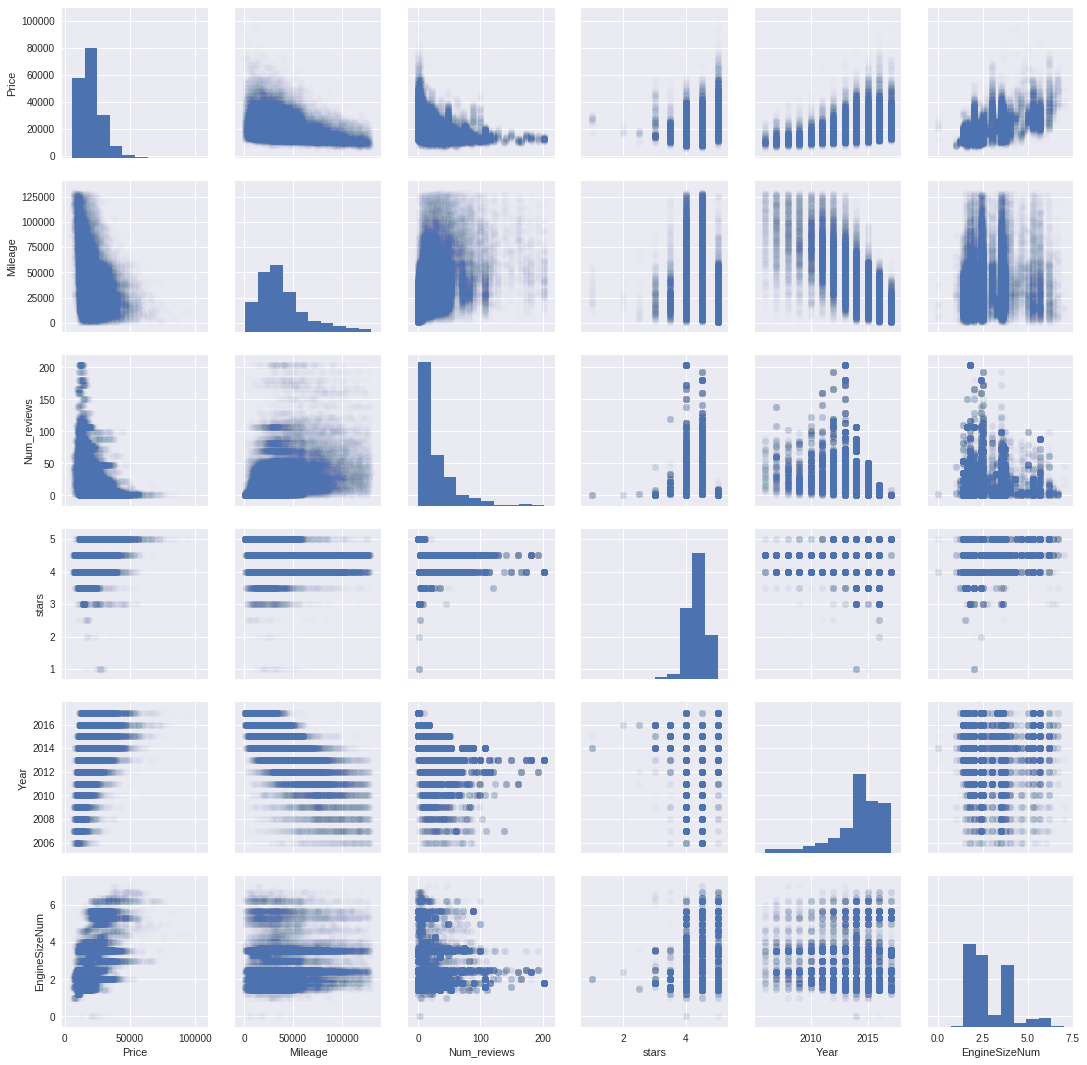

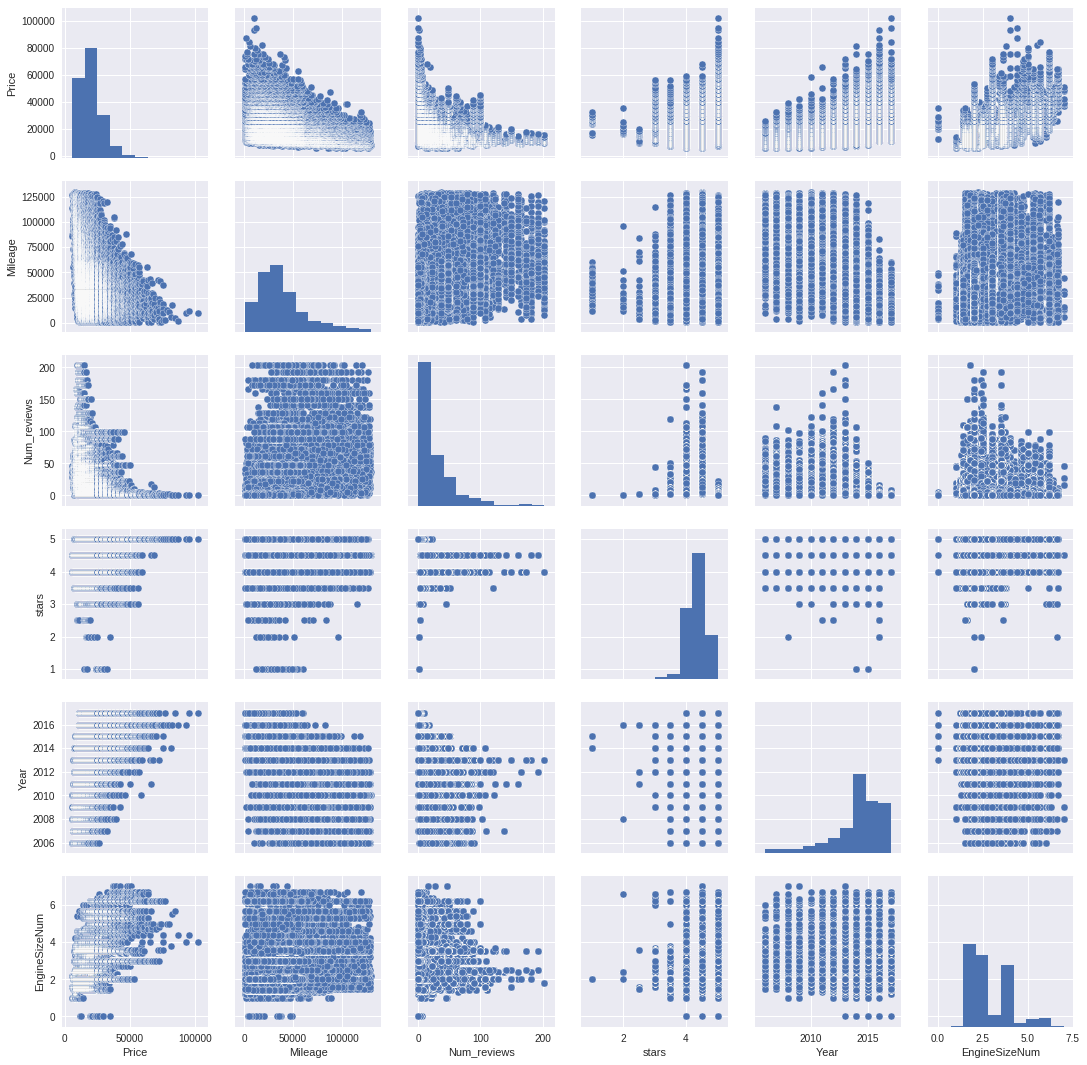

In [7]:
#appends new numbers to a new DF. This df only contains the desired numerical variables. Pair plots
#df4 is only for pair plots
ImageRes=250
df4=pd.DataFrame()
df4['Price']=PriceNum
df4['Mileage']=MileageNum
df4['Num_reviews']=df3.Num_reviews
#df4.features
df4['stars']=df3.stars
df4['Year']=df3.Year
df4['EngineSizeNum']=EngineSizeNum

sns.pairplot(df4.dropna(), plot_kws={'alpha':.01})
plt.savefig('pairplotAllAlpha.png', dpi=ImageRes)
plt.show()
sns.pairplot(df4.dropna(), plot_kws={'alpha':1})
plt.savefig('pairplotAll.png', dpi=ImageRes)
plt.show()

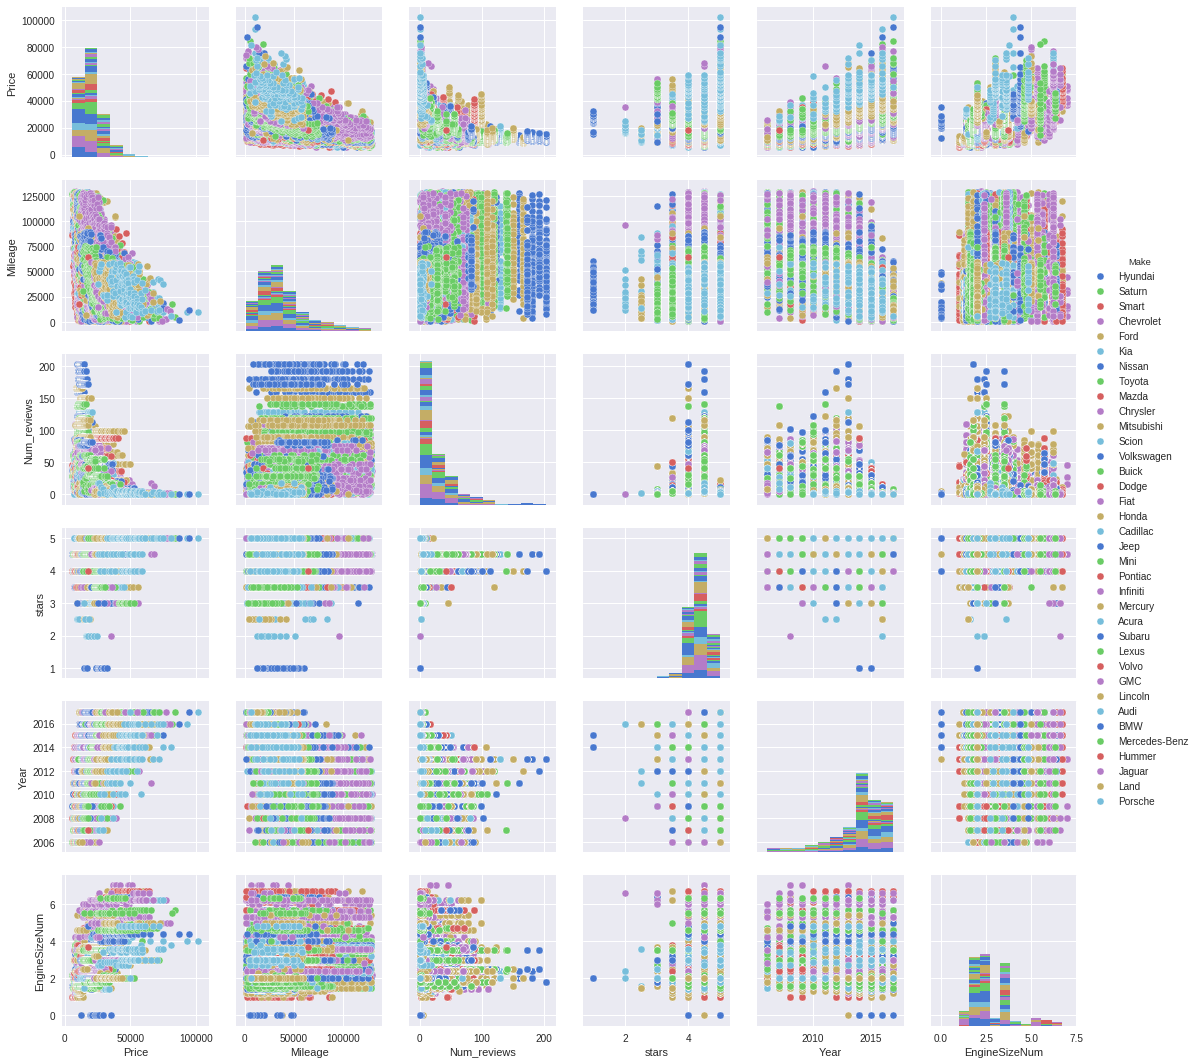

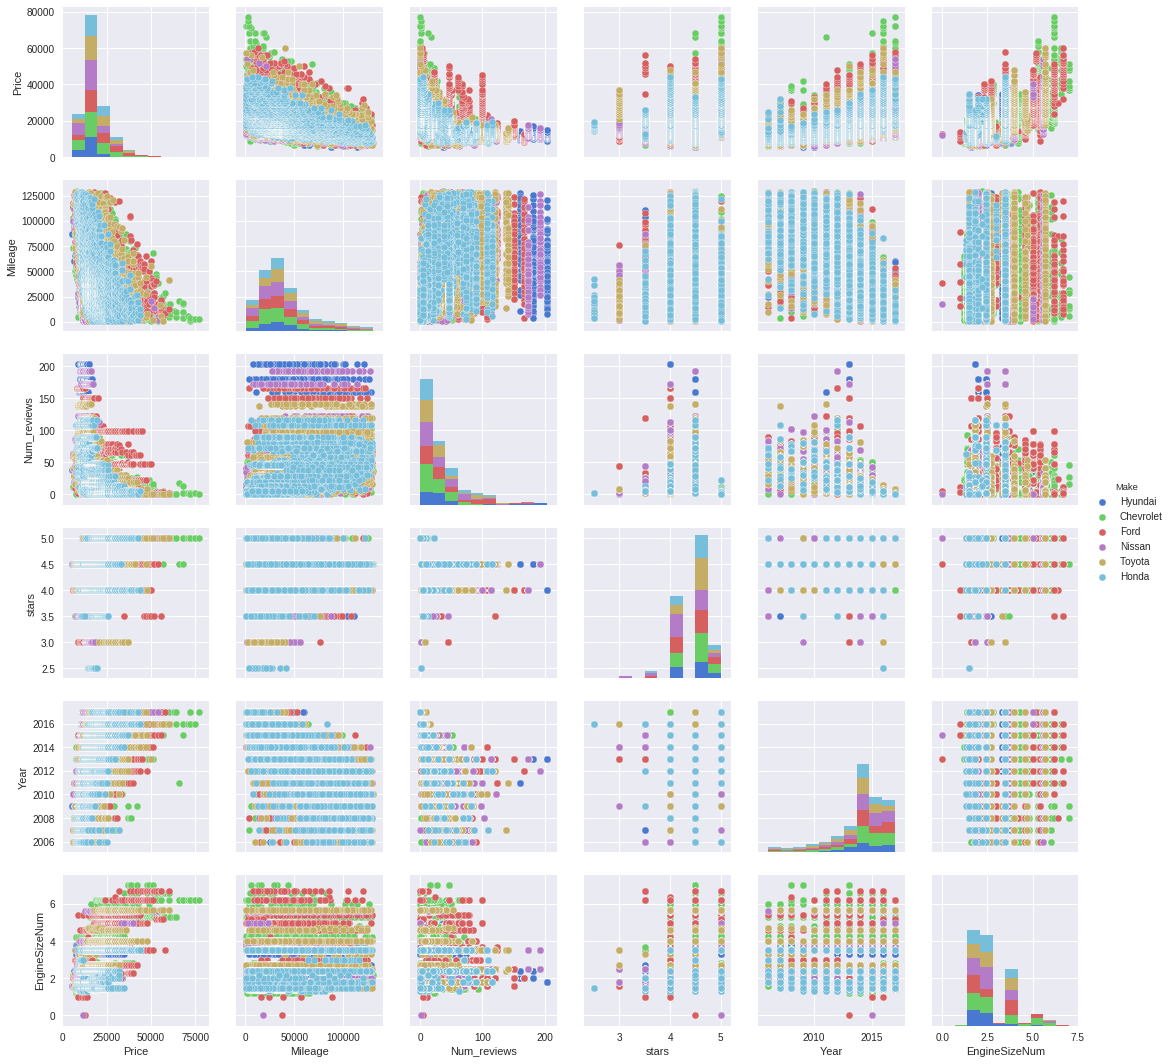

In [18]:
#only use to make the graphs that have colors by make
df4['Make']=df3.Make
sns.pairplot(df4,plot_kws={'alpha':1}, hue="Make", palette="muted")
plt.savefig('pairplotAllMake.png' ,dpi=ImageRes)
plt.show()

sns.pairplot(df4.loc[df4['Make'].isin(['Chevrolet','Nissan','Ford','Toyota','Honda','Hyundai'])].dropna(),\
             plot_kws={'alpha':1}, hue="Make", palette="muted")
plt.savefig('pairplot6Make.png' ,dpi=ImageRes)
plt.show()
df4.drop(['Make'], axis=1, inplace=True)

<h1>Dummy Variable creation for regression analysis</h1>

In [8]:
#Makes ~2000 Dummies and final dataframe
Colorlist=[]
Statelist=[]
TransAuto=[]
dfFinal=pd.DataFrame()

for i in list(df3.Color):
    Colorlist.append(str(i).split('/')[0])
for i in list(df3.location):
    Statelist.append(str(i).split(',')[-1].strip())
for i in list(df3.TransmissionType):
    if i =='Automatic':TransAuto.append('1')
    else: TransAuto.append('0')
df3['ColorSimplified']=Colorlist
df3['State']=Statelist
df3['0']=TransAuto
df3.Make.replace('Genesis','Hyundai', inplace=True)
dfFinal=pd.concat([df4, pd.get_dummies(df3['Make']), pd.get_dummies(df3['Model']), pd.get_dummies(df3['location']), \
           pd.get_dummies(df3['WD']), pd.get_dummies(df3['ColorSimplified']),\
          pd.get_dummies(df3['State']),df3['0'] , pd.get_dummies(df3['TransmissionSpeed'])], axis=1);


<h3>Split data into training and testing sets</h3>

In [9]:
dfFinal[:1]

,Price,Mileage,Num_reviews,stars,Year,EngineSizeNum,Acura,Audi,BMW,Buick,...,TX,UT,VA,WA,WI,0,4,5,6,7
0,5599.0,87000.0,38.0,4.5,2009.0,1.6,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(dfFinal.dropna().iloc[:,1:], dfFinal.dropna().loc[:,'Price'], test_size=0.1,random_state=42)
kfold = KFold(len(X_train), n_folds=5, shuffle=True, random_state=42)

<h1>Linear Regression</h1>

Training Data with linear regression


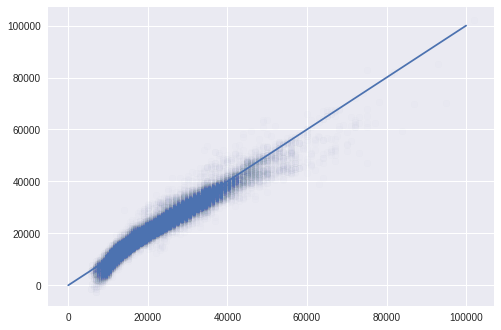

Testing Data with linear regression


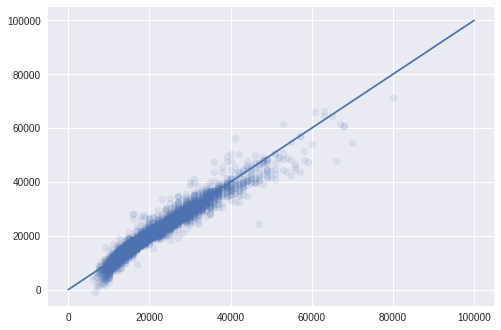

In [22]:
# Build the linear Model
print('Training Data with linear regression')
lin_reg_est = LinearRegression()
lin_reg_est.fit(X_train, y_train)

y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.01)
plt.plot([0, W], [0, W])
plt.savefig('linear+train.png', dpi=500)
plt.show()

#measures the test against the predicted

y_test_pred = lin_reg_est.predict(X_test)
print('Testing Data with linear regression')
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([0, W], [0, W])
plt.savefig('linear+test.png', dpi=500)
plt.show()

In [450]:
scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
r2_score(y_test, y_test_pred)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

#Write lin reg coeffs to csv
coeffs=pd.DataFrame()
coeffs['variables']=X_train.columns
coeffs['values']=lin_reg_est.coef_
coeffs.to_csv('coeffs.csv')

[ 0.93045331  0.93119338  0.93749083  0.92783011  0.92643411]
Linear Reg Mean Score:  0.930680347935
R-Squared Score: 0.9437186050143188
RMSE: 1989.8716041642392


In [220]:
#cv_preds = cross_val_predict(lin_reg_est, X_train, y_train, cv=kfold)

<h1>Lasso, LassoCV Regressions</h1>

Training Data with Lasso Regression


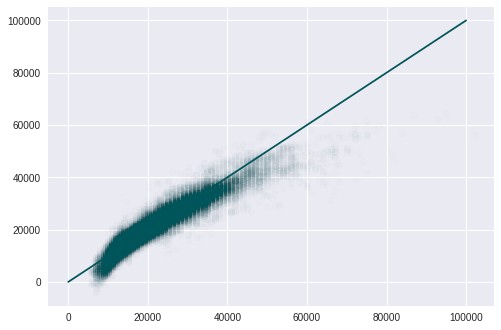

Testing Data with Lasso Regression


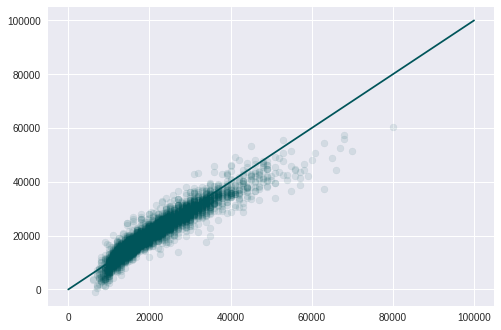

In [221]:
alpha=1
lasso_est = Lasso(alpha=alpha)
lasso_est.fit(X_train, y_train)
y_train_pred = lasso_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.01)
plt.plot([0, W], [0, W])
print('Training Data with Lasso Regression')
plt.savefig('lasso+train.png', dpi=500)
plt.show()

y_test_pred = lasso_est.predict(X_test)
print('Testing Data with Lasso Regression')
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([0, W], [0, W])
plt.savefig('lasso+test.png', dpi=500)
plt.show()

In [222]:
lasso_scores = cross_val_score(lasso_est, X_train, y_train, cv=kfold)

r2_score(y_test, y_test_pred)
print(lasso_scores)
print("Lasso Reg Mean Score: ", np.mean(lasso_scores))
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))
print("Mean Abs Error: {}".format(mean_absolute_error(y_test, y_test_pred)))

[ 0.88097583  0.88911986  0.89309283  0.88627485  0.88921113]
Lasso Reg Mean Score:  0.8877348996
R-Squared Score: 0.893982129374214


In [223]:
#LassoCV regression
alphavec=np.logspace(-5,5, 5)
lr_model6 = LassoCV(alphas = alphavec, cv=5)
lr_model6.fit(X_train,y_train)
lr_model6.alpha_

.


/home/sufyan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


.


/home/sufyan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0031622776601683794

In [224]:
#Write lassoCV reg coeffs to csv
coeffs=pd.DataFrame()
coeffs['variables']=X_train.columns
coeffs['values']=lr_model6.coef_
coeffs.to_csv('coeffs_LassoCV.csv')

<h1>Ridge Regression</h1>

Ridge Regression on training data


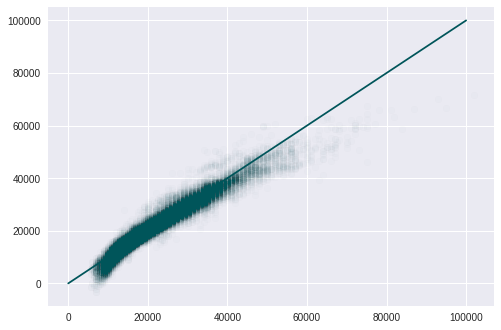

Ridge Regression+test


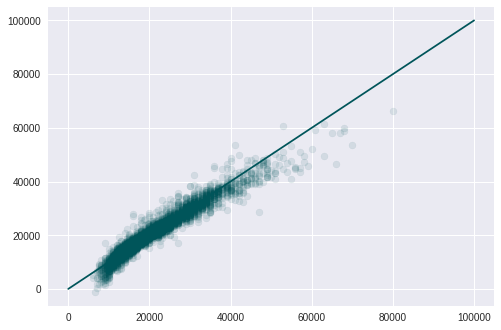

In [225]:
ridge_est = Ridge(alpha=alpha)
ridge_est.fit(X_train, y_train)


y_train_pred = ridge_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.01)
plt.plot([0, W], [0, W])
print('Ridge Regression on training data')
plt.savefig('ridge+train.png', dpi=500)
plt.show()

y_test_pred = ridge_est.predict(X_test)
print('Ridge Regression+test')
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([0, W], [0, W])
plt.savefig('ridge+test.png', dpi=500)
plt.show()

In [226]:
ridge_scores = cross_val_score(ridge_est, X_train, y_train, cv=kfold)

r2_score(y_test, y_test_pred)
print(ridge_scores)
print("Ridge Reg Mean Score: ", np.mean(ridge_scores))
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))
print("Mean Abs Error: {}".format(mean_absolute_error(y_test, y_test_pred)))

[ 0.92467743  0.92681623  0.93230916  0.92461491  0.92341516]
Ridge Reg Mean Score:  0.926366578155
R-Squared Score: 0.9384585801302622


<h1>Elastic Net Regression</h1>

ElasticNet+training


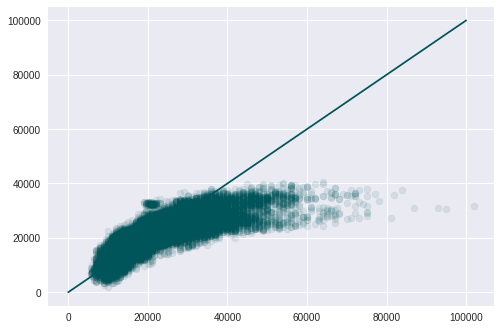

ElasticNet+testing


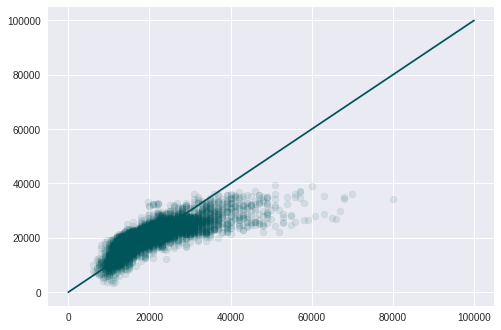

In [227]:
elas_reg=ElasticNet(alpha=alpha)
elas_reg.fit(X_train,y_train)

y_train_pred=elas_reg.predict(X_train)
plt.scatter(y_train,y_train_pred,alpha=.1)
plt.plot([0, W], [0, W])
plt.savefig('elastic+train.png', dpi=500)
print('ElasticNet+training')
plt.show()

y_test_pred = elas_reg.predict(X_test)
print('ElasticNet+testing')
plt.scatter(y_test, y_test_pred, alpha=.1)
plt.plot([0, W], [0, W])
plt.savefig('ElasticNet+testing.png', dpi=500)
plt.show()

In [228]:
elas_reg.coef_

elas_scores=cross_val_score(elas_reg,X_train,y_train,cv=kfold)
print(elas_scores)
print("ElasticNet Reg Mean Score: ", np.mean(elas_scores))
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))
print("Mean Abs Error: {}".format(mean_absolute_error(y_test, y_test_pred)))

[ 0.59045013  0.59918995  0.59843683  0.58069527  0.58967777]
ElasticNet Reg Mean Score:  0.591689988207
R-Squared Score: 0.5894282509660522


<h1>RandomForests</h1>

In [235]:
#plt.hist(df.medianHouseValue,range=[0,600000],bins=600);

RandFor_reg = RandomForestRegressor(n_estimators = 100, max_features = 3,
                                min_samples_leaf = 5, n_jobs=4)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.053406592372588935


In [237]:
RandFor_reg = RandomForestRegressor(n_estimators = 1000, max_features = 3,
                                min_samples_leaf = 5, n_jobs=4)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.05800639783375272


In [239]:
RandFor_reg = RandomForestRegressor(n_estimators = 1000, max_features = 4,
                                min_samples_leaf = 5, n_jobs=4)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.12378065827096707


In [240]:
RandFor_reg = RandomForestRegressor(n_estimators = 2000, max_features = 4,
                                min_samples_leaf = 5, n_jobs=4)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.12723639464826353


In [243]:
%%time
RandFor_reg = RandomForestRegressor(n_estimators = 2000, max_features = 8,
                                min_samples_leaf = 5, n_jobs=4)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.4365871655790825
CPU times: user 2min 22s, sys: 764 ms, total: 2min 23s
Wall time: 41 s


In [242]:
%%time
RandFor_reg = RandomForestRegressor(n_estimators = 2000, max_features = 8,
                                min_samples_leaf = 5, n_jobs=-1)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.4381276943914373
CPU times: user 4min 31s, sys: 676 ms, total: 4min 31s
Wall time: 41.2 s


In [244]:
%%time
RandFor_reg = RandomForestRegressor(n_estimators = 2000, max_features = 12,
                                min_samples_leaf = 5, n_jobs=-1)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.5713174210315722
CPU times: user 8min 6s, sys: 844 ms, total: 8min 7s
Wall time: 1min 8s


In [245]:
%%time
RandFor_reg = RandomForestRegressor(n_estimators = 1000, max_features = 12,
                                min_samples_leaf = 5, n_jobs=-1)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.5751557534791731
CPU times: user 3min 55s, sys: 572 ms, total: 3min 56s
Wall time: 34.7 s


In [246]:
%%time
RandFor_reg = RandomForestRegressor(n_estimators = 2000, max_features = 24,
                                min_samples_leaf = 5, n_jobs=-1)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("R-Squared Score: {}".format(r2_score(y_test, y_test_pred)))

R-Squared Score: 0.7193448617609433
CPU times: user 15min 59s, sys: 784 ms, total: 15min 59s
Wall time: 2min 8s


In [257]:
%%time
i=[40,45,50,55,100,250,500,1000]
for j in i:
    RandFor_reg = RandomForestRegressor(n_estimators = 1000, max_features = j,
                                    min_samples_leaf = 5, n_jobs=-1)
    RandFor_reg.fit(X_train,y_train)
    y_test_pred = RandFor_reg.predict(X_test)
    sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
    print("{}: R-Squared Score: {}".format(j, r2_score(y_test, y_test_pred)))

40: R-Squared Score: 0.7820387099018711
45: R-Squared Score: 0.7949835727764447
50: R-Squared Score: 0.8039289951965622
55: R-Squared Score: 0.8120872838797946
100: R-Squared Score: 0.860438888544953
250: R-Squared Score: 0.9055418443356633
500: R-Squared Score: 0.9203035344964303
1000: R-Squared Score: 0.9254037088848219
CPU times: user 3h 22min 36s, sys: 8.43 s, total: 3h 22min 45s
Wall time: 26min 47s


In [416]:
%%time
RandFor_reg = RandomForestRegressor(n_estimators = 1000, max_features = 1500,
                                min_samples_leaf = 5, n_jobs=-1)
RandFor_reg.fit(X_train,y_train)
y_test_pred = RandFor_reg.predict(X_test)
sorted(zip(X_train.columns,abs(RandFor_reg.feature_importances_)), key=lambda x: -x[1])
print("{}: R-Squared Score: {}".format('1500', r2_score(y_test, y_test_pred)))

1500: R-Squared Score: 0.9259293079463407


<h1>Create exponential features and complete linear regression analysis</h1>

In [11]:
dfExpon=dfFinal.copy()
#other variables were tested but were found to increase score negligibly
dfExpon['EYear']=dfExpon['Year']**2
X_trainB, X_testB, y_trainB, y_testB = train_test_split(dfExpon.dropna().iloc[:,1:], dfExpon.dropna().loc[:,'Price'], test_size=0.1,random_state=42)

In [14]:
lin_reg=LinearRegression()
lin_reg.fit(X_testB,y_testB)
y_test_predB = lin_reg.predict(X_testB)

plt.scatter(y_testB, y_test_predB, alpha=0.1)
plt.plot([0, W], [0, W])
plt.savefig('linear+test+EYear.png', dpi=500)

print("R-Squared Score: {}".format(r2_score(y_testB, y_test_predB)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testB, y_test_predB))))

R-Squared Score: 0.9629898238452789
RMSE: 1613.6271930413648


<h1>Replacing Dummies with coeffs of things</h1>

In [15]:
lincoeffs=pd.read_csv('coeffs.csv')
coeffdict={}
l1=list(lincoeffs.variables)
l2=list(lincoeffs['values'])
for i in range(len(l1)):
    coeffdict[l1[i]]=l2[i]
    #lincoeffs['variables']
    
lmake=list(df3.Make)
lcolor=list(df3.ColorSimplified)
lmodel=list(df3.Model)

l4=[]
l5=[]
l6=[]
for i in range(len(lmake)):
    l4.append(coeffdict[lmake[i]])
#    l5.append(coeffdict[lcolor[i]])
#    l6.append(coeffdict[lmodel[i]])
list(zip(l4, list(df3.Make)))

dfCoeff=df4.copy()
dfCoeff['CoeMake']=l4
#dfCoeff['CoeColor']=l5
#dfCoeff['CoeModel']=l6

<h1>RandomForest with coeff replaced dummies</h1>

In [16]:
X_trainC, X_testC, y_trainC, y_testC = train_test_split(dfCoeff.dropna().iloc[:,1:], dfCoeff.dropna().loc[:,'Price'], test_size=0.1,random_state=42)


In [27]:
%%time
i=[40,45,50,55,100,250,500,1000]
for j in i:
    RandFor_reg2 = RandomForestRegressor(n_estimators = 1000, max_features = j,
                                    min_samples_leaf = 5, n_jobs=-1)
    RandFor_reg2.fit(X_train,y_train)
    y_test_pred = RandFor_reg2.predict(X_test)
    sorted(zip(X_train.columns,abs(RandFor_reg2.feature_importances_)), key=lambda x: -x[1])
    print("{}: R-Squared Score: {}".format(j, r2_score(y_test, y_test_pred)))

KeyboardInterrupt: 

<h1>Gradient Boosted Regressor</h1>

In [425]:
%%time
gbmodel=GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.1, subsample=1.0)
gbmodel.fit(X_train, y_train)
y_test_pred_gb1=gbmodel.predict(X_test)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_test, y_test_pred_gb1)))

1000: R-Squared Score: 0.8960063212571009
CPU times: user 8min 17s, sys: 868 ms, total: 8min 18s
Wall time: 8min 18s


In [460]:
%%time
gbmodel=GradientBoostingRegressor(n_estimators=1000, max_depth=3, learning_rate=.1, subsample=1.0, max_features=500, min_samples_leaf = 5)
gbmodel.fit(X_train, y_train)
y_test_pred_gb1=gbmodel.predict(X_test)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_test, y_test_pred_gb1)))
print('Importance: {}'.format(gbmodel.feature_importances_))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_test_pred_gb1))))


1000: R-Squared Score: 0.9152101827533358
Importance: [  3.71496450e-02   3.17693766e-02   1.31597904e-02 ...,   1.53533072e-03
   1.16161746e-03   6.09462037e-06]
RMSE: 2442.386987997298
CPU times: user 4min 28s, sys: 984 ms, total: 4min 29s
Wall time: 4min 29s


<h1>Gradent Boosted+Lin Coeffs</h1>

In [431]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=1000, max_depth=3, learning_rate=.1, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))

1000: R-Squared Score: 0.9686186155842275
RMSE: 1485.8626890365024
CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 13.1 s


In [433]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=1000, max_depth=4, learning_rate=.1, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9732801818849754
RMSE: 1371.0692058619
Importance: {}
CPU times: user 19 s, sys: 4 ms, total: 19 s
Wall time: 19 s


In [435]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9764825260678139
RMSE: 1286.2872464108407
Importance: {}
CPU times: user 53.6 s, sys: 8 ms, total: 53.6 s
Wall time: 53.6 s


In [436]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=1000, max_depth=7, learning_rate=.1, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9748930580320952
RMSE: 1329.0445452825309
Importance: {}
CPU times: user 52.8 s, sys: 4 ms, total: 52.8 s
Wall time: 52.8 s


In [437]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=1000, max_depth=10, learning_rate=.1, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.972909552648312
RMSE: 1380.5454734002676
Importance: {}
CPU times: user 2min 7s, sys: 0 ns, total: 2min 7s
Wall time: 2min 7s


In [438]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.05, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9750431372428611
RMSE: 1325.066344218213
Importance: {}
CPU times: user 57.4 s, sys: 4 ms, total: 57.4 s
Wall time: 57.4 s


In [439]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.15, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.975474405299989
RMSE: 1313.5675204956945
Importance: {}
CPU times: user 56.2 s, sys: 8 ms, total: 56.2 s
Wall time: 56.2 s


In [440]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.2, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9754189571102534
RMSE: 1315.0515583267877
Importance: {}
CPU times: user 59.1 s, sys: 24 ms, total: 59.1 s
Wall time: 59.1 s


In [441]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 5)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9764777619672861
RMSE: 1286.4175259521423
Importance: {}
CPU times: user 58.6 s, sys: 4 ms, total: 58.6 s
Wall time: 58.6 s


In [442]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 3)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9767418073522732
RMSE: 1279.176904661042
Importance: {}
CPU times: user 57.8 s, sys: 0 ns, total: 57.8 s
Wall time: 57.8 s


In [443]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 4)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.9768148774861731
RMSE: 1277.1659324861673
Importance: {}
CPU times: user 59.2 s, sys: 8 ms, total: 59.2 s
Wall time: 59.3 s


In [445]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 6)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.976511856060174
RMSE: 1285.4848948195765
Importance: {}
CPU times: user 57.1 s, sys: 20 ms, total: 57.2 s
Wall time: 57.2 s


In [446]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 7)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}')

1000: R-Squared Score: 0.976437464004367
RMSE: 1287.5189904853194
Importance: {}
CPU times: user 56.1 s, sys: 0 ns, total: 56.1 s
Wall time: 56.2 s


<h1>Final Regression Utilizing Linear Coefficients and Optimized parameters</h1>

In [32]:
%%time
#with coeff replaced dummies
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 4)
gbmodel.fit(X_trainC, y_trainC)
y_test_pred_gb1C=gbmodel.predict(X_testC)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_pred_gb1C)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_pred_gb1C))))
print('Importance: {}'.format(gbmodel.feature_importances_))

40: R-Squared Score: 0.9092766857213659
RMSE: 2526.3998195280888
Importance: [ 0.24683698  0.23416098  0.0440737   0.10907821  0.20483223  0.1610179 ]
CPU times: user 44.2 s, sys: 0 ns, total: 44.2 s
Wall time: 44.2 s


In [459]:
#tried again with RandomForest...pretty good, but not good enough
RandFor_reg2 = RandomForestRegressor(n_estimators = 2000 , n_jobs=-1)
RandFor_reg2.fit(X_trainC,y_trainC)
y_test_predC = RandFor_reg2.predict(X_testC)
sorted(zip(X_train.columns,abs(RandFor_reg2.feature_importances_)), key=lambda x: -x[1])
print("{}: R-Squared Score: {}".format(j, r2_score(y_testC, y_test_predC)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testC, y_test_predC))))
print('Importance: {}'.format(RandFor_reg2.feature_importances_))

1000: R-Squared Score: 0.9700397035384387
RMSE: 1451.8297156828808
Importance: [ 0.05680576  0.06455559  0.0032924   0.10335519  0.05520827  0.20396054
  0.00472855  0.5080937 ]


<h1>Adds Missing Variables into the df for New GB Regressor</h1>

In [92]:
lincoeffs=pd.read_csv('coeffs.csv')
coeffdict={}
l1=list(lincoeffs.variables)
l2=list(lincoeffs['values'])
for i in range(len(l1)):
    coeffdict[l1[i]]=l2[i]
    #lincoeffs['variables']

lmake=list(df3.Make)
lcolor=list(df3.ColorSimplified)
lmodel=list(df3.Model)
lstate=list(df3.State)
lspd=list(df3.TransmissionSpeed)

for i in range(len(lspd)):
    if lspd[i] is None: lspd[i]='0'

l4=[]
l5=[]
l6=[]
l7=[]
l8=[]
for i in range(len(lmake)):
    l4.append(coeffdict[lmake[i]])
    l5.append(coeffdict[lcolor[i]])
    l6.append(coeffdict[lmodel[i]])
    l7.append(coeffdict[lstate[i]])
    l8.append(coeffdict[lspd[i]])

dfCoeff2=dfCoeff.copy()
dfCoeff2['CoeMake']=l4
dfCoeff2['CoeColor']=l5
dfCoeff2['CoeModel']=l6
dfCoeff2['CoeState']=l7
dfCoeff2['CoeTrSpd']=l8

In [83]:
X_trainD, X_testD, y_trainD, y_testD = train_test_split(dfCoeff2.dropna().iloc[:,1:], dfCoeff2.dropna().loc[:,'Price'], test_size=0.1)


In [19]:
%%time
#with coeff replaced dummies
bestrand=0
randlist=[]
#for i in range(50):
gbmodel=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 5, random_state=25)
gbmodel.fit(X_trainD, y_trainD)
y_test_pred_gb1D=gbmodel.predict(X_testD)
#np.sqrt(np.mean((y_pred_gb1 - y_test)**2))


bestrand=r2_score(y_testD, y_test_pred_gb1D)
randlist.append(i)
print("R-Squared Score: {}".format(r2_score(y_testD, y_test_pred_gb1D)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testD, y_test_pred_gb1D))))
print('Importance: {}'.format(gbmodel.feature_importances_))

R-Squared Score: 0.9795598266710168
RMSE: 1176.3467025899442
Importance: [ 0.17605675  0.10599337  0.02000305  0.06573924  0.08809646  0.08307558
  0.0563025   0.29183567  0.1078951   0.00500228]
CPU times: user 1min 7s, sys: 4 ms, total: 1min 7s
Wall time: 1min 7s


**Random State:42**
R-Squared Score: 0.976707946800561
RMSE: 1280.107713930252
Importance: [ 0.17999564  0.09795774  0.01981877  0.06889674  0.08695065  0.08447993
  0.05856138  0.28636112  0.11182591  0.00515212]
**None Set**
R-Squared Score: 0.9786888775702606
RMSE: 1215.6058651903008
Importance: [ 0.17987597  0.10089569  0.02106931  0.0697526   0.08659966  0.08211057
  0.05307687  0.28983896  0.11139384  0.00538654]
CPU times: user 1min 9s, sys: 8 ms, total: 1min 9s
Wall time: 1min 9s
**RS: 25**
R-Squared Score: 0.9787057627728855
RMSE: 1215.124196081611
Importance: [ 0.1801661   0.10135717  0.02107424  0.06886257  0.08649622  0.08184392
  0.05299646  0.29034641  0.1114024   0.0054545 ]
CPU times: user 1min 9s, sys: 8 ms, total: 1min 9s
Wall time: 1min 9s
**max depth=5**
R-Squared Score: 0.9789264657139796
RMSE: 1208.8107509557344
Importance: [ 0.17265193  0.10417228  0.02116008  0.06812109  0.09056816  0.08392779
  0.05506636  0.29423984  0.10529009  0.00480239]

In [36]:
randlist

[51161]

In [40]:
MyMazda=[60000,18,4.5,2013,2.0,-6549.76046287918,118.175573224979,-4404.52520704963,191.844234592083,95.200525637948]

In [38]:
dfCoeff2.columns

Index(['Price', 'Mileage', 'Num_reviews', 'stars', 'Year', 'EngineSizeNum',
       'CoeMake', 'CoeColor', 'CoeModel', 'CoeState', 'CoeTrSpd'],
      dtype='object')

In [39]:
gbmodel.predict(MyMazda)
bestmodel=gbmodel
bestmodel.predict(MyMazda)
#([ 11966.13927998])

/home/sufyan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sufyan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 11757.25976039])

In [40]:
print("MAD: {}".format(mean_absolute_error(y_testD, y_test_pred_gb1D)))

MAD: 825.255749910533


<h1>Added WD column which was forgotten earlier, rerun GB, and export GB as pickle</h1>

In [99]:
lWD=list(df3['WD'])
l9=[]
for i in range(len(lWD)):
    l9.append(coeffdict[lWD[i]])
dfCoeff2['CoeWD']=l9

In [100]:
X_trainE, X_testE, y_trainE, y_testE = train_test_split(dfCoeff2.dropna().iloc[:,1:], dfCoeff2.dropna().loc[:,'Price'], test_size=0.1)


In [93]:
%%time
#gbmodelE was used and is still active at R2=0.98215 or must be de-pickled in next cell, RMSE 1108.005929
gbmodelE2=GradientBoostingRegressor(n_estimators=2000, max_depth=5, learning_rate=.1, subsample=1.0, min_samples_leaf = 1, random_state=25)
gbmodelE2.fit(X_trainE, y_trainE)
y_test_pred_gb1E=gbmodelE2.predict(X_testE)

print("R-Squared Score: {}".format(r2_score(y_testE, y_test_pred_gb1E)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testE, y_test_pred_gb1E))))
print("MAE: {}".format(mean_absolute_error(y_testE, y_test_pred_gb1E)))
print('Importance: {}'.format(gbmodelE2.feature_importances_))

R-Squared Score: 0.9772135796996565
RMSE: 1250.8510062516498
MAE: 787.6089897473887
Importance: [ 0.16942642  0.10069583  0.02045774  0.07103348  0.07886518  0.08758249
  0.05538555  0.27401297  0.10309121  0.00724861  0.00912232  0.0230782 ]
CPU times: user 1min 25s, sys: 4 ms, total: 1min 25s
Wall time: 1min 25s


<h3>Pickle File Made Containing gbmodelE</h3>

In [33]:
#pickle.dump(gbmodelE, open("gbmodelE1.pickle.dat", "wb"))
gbmodelE = pickle.load(open("gbmodelE1.pickle.dat", "rb"))

In [49]:
gbmodelE.predict(MyMazda)

/home/sufyan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 11972.74274875])

In [50]:
rlist=[]


In [105]:
%%time
for i in range(1000):
    X_trainE, X_testE, y_trainE, y_testE = train_test_split(dfCoeff2.dropna().iloc[:,1:], dfCoeff2.dropna().loc[:,'Price'], test_size=0.05)

    y_test_pred_gb1E=gbmodelE.predict(X_testE)
    rlist.append(r2_score(y_testE, y_test_pred_gb1E))
#     print("R-Squared Score: {}".format(r2_score(y_testE, y_test_pred_gb1E)))
#     print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testE, y_test_pred_gb1E))))
#     print('Importance: {}'.format(gbmodelE.feature_importances_))

CPU times: user 1min 41s, sys: 44 ms, total: 1min 41s
Wall time: 1min 41s


<h1>Insights Boosting Model</h1>

In [129]:
mlitest= X_testE.sample(500)
mxr=mli.ModelXRay(gbmodelE,mlitest)

In [148]:
mlitest.iloc[[403,  97, 267, 212, 325,  42, 278]]

,Mileage,Num_reviews,stars,Year,EngineSizeNum,CoeMake,CoeColor,CoeModel,CoeState,CoeTrSpd,CoeWD
24702,25000.0,6.0,4.5,2016.0,2.5,82.967363,120.598039,-9049.246760,45.774713,95.200526,-788.0899
23722,36000.0,41.0,4.5,2014.0,3.7,-280.389323,120.598039,-6774.268040,191.844235,95.200526,-788.0899
17450,25000.0,70.0,4.0,2014.0,2.5,-3573.284729,243.063582,-6096.315536,240.702425,95.200526,-788.0899
213,97000.0,62.0,4.5,2010.0,2.0,-280.389323,120.598039,-11118.864556,-62.075949,95.200526,-788.0899
36914,12000.0,0.0,5.0,2014.0,3.5,-1109.681860,120.598039,-2681.970063,176.727066,95.200526,-788.0899
42424,17000.0,2.0,4.0,2015.0,2.0,7387.653664,-7.777911,-9885.165442,210.129493,95.200526,-788.0899
20326,34000.0,16.0,4.5,2015.0,2.4,82.967363,-7.777911,-7355.456461,-72.655396,95.200526,-788.0899


In [184]:
df3.loc[42424,:]

Unnamed: 0                                                          77
YearMakeModel                                           2015 BMW 228 I
Price                                                           27,998
Mileage                                                            17K
Num_reviews                                                          2
location                                                     Miami, FL
features             Run Flat Tires, Turbo Charged Engine, Leather ...
specs                4 Cylinders, 2WD, 2.0L Engine, Automatic Trans...
stars                                                                4
Year                                                              2015
Make                                                               BMW
Model                                                            228 I
Cylinders                                                  4 Cylinders
WD                                                                 2WD
Engine

In [185]:
mliindices=mxr.feature_dependence_plots(pts_selected=np.arange(7))
mlitest.iloc[mliindices,:]

,Mileage,Num_reviews,stars,Year,EngineSizeNum,CoeMake,CoeColor,CoeModel,CoeState,CoeTrSpd,CoeWD
42668,24000.0,37.0,4.5,2015.0,3.6,-381.956140,-7.777911,1210.775673,-182.092810,95.200526,788.089901
15194,31000.0,21.0,4.0,2015.0,2.0,-2053.199521,243.063582,-8737.085355,210.129493,95.200526,-788.089900
18225,35000.0,24.0,4.5,2014.0,2.4,-381.956140,118.175573,-9360.345788,-182.092810,95.200526,-788.089900
41332,34000.0,1.0,1.0,2014.0,2.0,7387.653664,87.697289,-5047.696021,176.727066,95.200526,788.089901
9271,23000.0,2.0,5.0,2016.0,1.8,-7129.730480,120.598039,-6655.676152,311.982863,95.200526,-788.089900
9953,24000.0,16.0,4.0,2014.0,2.4,-5480.009283,118.175573,-4865.706710,191.844235,95.200526,-788.089900
28171,28000.0,30.0,4.0,2014.0,2.4,-2053.199521,243.063582,-4644.372914,176.727066,95.200526,788.089901


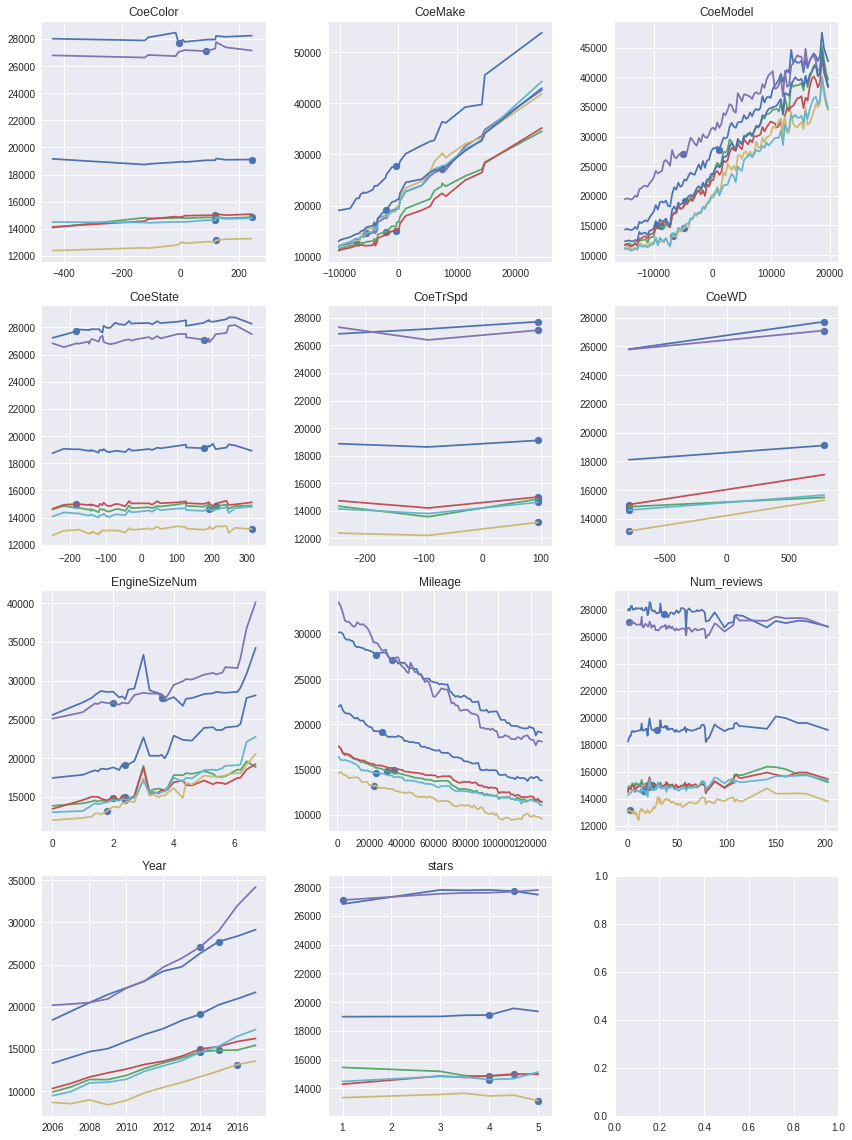

In [186]:
plt.savefig("gbmodelE_Insights.png", dpi=ImageRes)
plt.show()

NameError: name 'python' is not defined

In [188]:
mxr.results

{'CoeColor': (array([-439.15118797, -123.16795142, -111.83112445,  -17.45601242,
           -7.77791079,    5.07283399,    9.16180663,   12.29509097,
           87.69728875,  118.17557322,  120.59803886,  153.91197212,
          243.06358235]),
  array([[ 28022.13408577,  27894.97766052,  28118.32328681, ...,
           28224.35222504,  28163.95105095,  28248.84566583],
         [ 14079.40946071,  14814.94725762,  14772.88645091, ...,
           14879.77023324,  14780.42187049,  14851.60574437],
         [ 14138.52512201,  14565.08497433,  14703.71021336, ...,
           15097.85762253,  15003.26627976,  15082.05788567],
         ..., 
         [ 18148.13684352,  18148.81578902,  18096.64653784, ...,
           18557.52912053,  18395.86663633,  18407.6986769 ],
         [ 21410.59623639,  21060.96653283,  20959.3118406 , ...,
           20791.79839736,  21009.52332735,  21188.95032637],
         [ 33066.97177514,  33043.86220974,  33026.94796261, ...,
           32867.76627066,  33267.

In [192]:
dfCoeff2.columns, df3.columns

(Index(['Price', 'Mileage', 'Num_reviews', 'stars', 'Year', 'EngineSizeNum',
        'CoeMake', 'CoeColor', 'CoeModel', 'CoeState', 'CoeTrSpd', 'CoeWD'],
       dtype='object'),
 Index(['Unnamed: 0', 'YearMakeModel', 'Price', 'Mileage', 'Num_reviews',
        'location', 'features', 'specs', 'stars', 'Year', 'Make', 'Model',
        'Cylinders', 'WD', 'EngineSize', 'TransmissionType',
        'TransmissionSpeed', 'Color', 'ColorSimplified', 'State', '0'],
       dtype='object'))

In [129]:
n=10
m=20
y_test_pred_gb1E=gbmodelE.predict(X_testE[n:m])

print("R-Squared Score: {}".format(r2_score(y_testE[n:m], y_test_pred_gb1E)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_testE[n:m], y_test_pred_gb1E))))
print("MAE: {}".format(mean_absolute_error(y_testE[n:m], y_test_pred_gb1E)))
print('Importance: {}'.format(gbmodelE2.feature_importances_))

R-Squared Score: 0.992816763539557
RMSE: 346.28993824690565
MAE: 295.49219038035045
Importance: [ 0.16942642  0.10069583  0.02045774  0.07103348  0.07886518  0.08758249
  0.05538555  0.27401297  0.10309121  0.00724861  0.00912232  0.0230782 ]


In [130]:
y_testE[n:m]

39463    24998.0
20554    16599.0
3663     11599.0
32235    20998.0
26634    18599.0
10899    13998.0
12057    13998.0
26827    18599.0
36964    23599.0
20390    16599.0
Name: Price, dtype: float64

In [131]:
y_test_pred_gb1E

array([ 24933.57992261,  16762.90028279,  12176.57293938,  21184.10852804,
        19000.7175948 ,  13972.83637951,  13668.84356027,  18953.69542184,
        23030.3359898 ,  16882.52298914])